In [2]:
import csv

def read_column_from_csv(csv_file, column_number):
    with open(csv_file, mode='r', encoding='utf-8') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)  # Skip the header row
        for row in csv_reader:
            if len(row) > column_number:
                yield row[column_number]

csv_file = "data/test.csv"  # Change this to your CSV file

train_labels = []
train_texts = []
count = 0

for value in read_column_from_csv(csv_file, 2):
    if value == "Toys & Games":
        train_labels.append(1)
        count += 1
    else:
        train_labels.append(0)
    # if "All" in value:
    #     value = value.replace("All ", "")
    # categories.append(value)

for value in read_column_from_csv(csv_file, 0):
    train_texts.append(value)

number = len(train_labels)

print(f"Products: {number}")
print(train_texts)
print(train_labels)

Products: 1872
['Clean Cham® Liquid Absorbing Chamois Cloth for Car Cleaning Microfiber Cloth Small 1 Piece 43 CM x 32 CM', 'KHADIJA 1200W 7 Inch Electric Car Polisher Machine 6 Months Warranty Combo With Backup Pad And Wool Buffing Pad Double Ins...', 'VMTC Tap Connector Set (2 Quick Connector, 1 tap Connector & Adapter) for Gardening & Pressure Washer Like Karchre, Bosch,...', 'KARCHER K 2.050 HIGH Pressure CAR Washer', '3m Car Care Cream Wax & 3m Microfiber Cloth', 'Wavex® Rubbing Compound Heavy Cut (460gm) Super Heavy Hard Cut', 'RESIL VISTA AC Vent Kleen Hygiene Foam (450ml)', 'Livronic® Removable Telescopic Car Wax Drag Nano Fiber Car Wash Brush Car Dusting Tool Car Mop Wax Dash Duster Exterior In...', 'Wavex Grit Safe and Detailing Car Wash Bucket', 'foxcare Leather Cleaner and Leather Detailer Kit for Use on Leather Apparel, Furniture, Car Interiors, Shoes, Boots, Bags...', 'FLOJOY Asian Pumps & Machineries 12V Self Priming & Automatic High Pressure Washer with Adjustable Spray

In [2]:
import csv

def read_column_from_csv(csv_file, column_number):
    with open(csv_file, mode='r', encoding='utf-8') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)  # Skip the header row
        for row in csv_reader:
            if len(row) > column_number:
                yield row[column_number]

csv_file = "data/Amazon-Products.csv"  # Change this to your CSV file

train_labels = []
train_texts = []

for value in read_column_from_csv(csv_file, 3):
    train_labels.append(value)

for value in read_column_from_csv(csv_file, 1):
    train_texts.append(value)

number = len(train_labels)

print(f"Unique categories: {number}")
print(train_texts[0])  # Convert set to list for printing, if needed

Unique categories: 551585
Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1 Convertible, Copper, Anti-Viral + Pm 2.5 Filter, 2023 Model, White, Gls18I3...


In [12]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score  # pip install scikit-learn

num_epochs = 5
max_length = 128  # Adjust according to your text length

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load the pre-trained BERT model and move it to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5).to(device)  # Change num_labels to match your number of classes

# Define your dataset class
class MyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Example dataset
# train_texts = ["Text 1", "Text 2", "Text 3"]
# train_labels = [0, 1, 2]  # Example labels for 3 classes, replace with your actual labels

# Determine a suitable batch size
initial_batch_size = 32  # Start with a higher batch size
current_batch_size = initial_batch_size
while True:
    try:
        # Attempt to create the DataLoader with the current batch size
        train_dataset = MyDataset(train_texts, train_labels, tokenizer, max_length)
        train_dataloader = DataLoader(train_dataset, batch_size=current_batch_size, shuffle=True)
        
        # If successful, break the loop
        break
    except Exception as e:
        print(f"Batch size {current_batch_size} failed with error: {e}")
        current_batch_size //= 2  # Reduce batch size by half
        print(f"Trying batch size {current_batch_size}")

print(f"Using batch size: {current_batch_size}")

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training loop
model.train()
for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)  # Move input to GPU
        attention_mask = batch['attention_mask'].to(device)  # Move attention mask to GPU
        labels = batch['label'].to(device)  # Move labels to GPU

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

# Save the model
model.save_pretrained("model/")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using batch size: 32


KeyboardInterrupt: 

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Evaluation
model.eval()
total_correct = 0
total_samples = 0

validation_texts = ["Star Wars Epic Hero Series Darth Vader 4 Action Figure", "Nerf Elite 2.0 Commander RD-6 Blaster, 12 Official Nerf Darts, 6-Dart Rotating Drum, Built-In Customizing Capabilities", "Auto Drive Car Wash Microfiber Sponge, Chenille Pile & Scrubber Back, Blue, 1 piece", "VIKING Wheel Brush for Rims, Cleaning Brush for Tires, Tire Brush for Car, Grey, 10.3 inch x 3.3 inch x 3.8 Inch"]
validation_labels = [1, 1, 0, 0]  # Example labels for validation, replace with your actual labels

# validation_texts = train_texts
# validation_labels = train_labels


validation_dataset = MyDataset(validation_texts, validation_labels, tokenizer, max_length)
validation_dataloader = DataLoader(validation_dataset, batch_size=8, shuffle=False)

with torch.no_grad():
    for batch in validation_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        total_correct += torch.sum(predictions == labels).item()
        total_samples += len(labels)

print(predictions.tolist())
accuracy = total_correct / total_samples
print("Validation Accuracy:", accuracy)

[1, 1, 0, 0]
Validation Accuracy: 1.0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Dylan Kangas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\transformers\optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Using batch size: 64
Epoch 1/2


Epoch 1/2, Avg. Loss: 1.0448
Epoch 2/2


Epoch 2/2, Avg. Loss: 0.4471


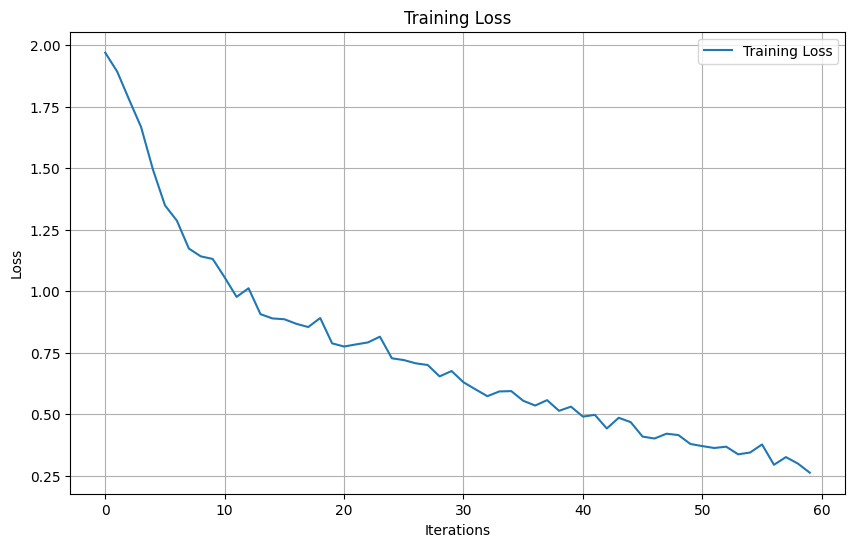

In [12]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

num_epochs = 2
max_length = 128

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load the pre-trained BERT model and move it to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5).to(device)

# Define your dataset class
class MyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Example dataset
# train_texts = ["Text 1", "Text 2", "Text 3"]
# train_labels = [0, 1, 2]  # Example labels for 3 classes, replace with your actual labels

# Determine a suitable batch size
initial_batch_size = 64
current_batch_size = initial_batch_size
while True:
    try:
        train_dataset = MyDataset(train_texts, train_labels, tokenizer, max_length)
        train_dataloader = DataLoader(train_dataset, batch_size=current_batch_size, shuffle=True)
        break
    except Exception as e:
        print(f"Batch size {current_batch_size} failed with error: {e}")
        current_batch_size //= 2
        print(f"Trying batch size {current_batch_size}")

print(f"Using batch size: {current_batch_size}")

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training loop with progress bars and loss collection
model.train()
losses = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    epoch_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        losses.append(loss.item())  # Append the current loss to the list

        progress_bar.set_postfix({'loss': epoch_loss / len(train_dataloader)})
    
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg. Loss: {avg_epoch_loss:.4f}")

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
model.save_pretrained("model/")
